In [1]:
import math

import matplotlib.pyplot as plt
import json
import csv
import numpy as np
import graph as g
import networkx as nx
import math
import homology as hm

import importlib
importlib.reload(g)

<module 'graph' from 'C:\\Users\\Willem\\PycharmProjects\\Topological-Learning\\src\\graph.py'>

In [2]:
def load_data():
    f = open("countries.geo.json")
    return json.load(f)

def load_csv_data(file_name):
    with open(file_name, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
        return data

gdp = load_csv_data('GDP.csv')

def attributes_for_country(country_code):
    max_gdp = max([float(x[-2]) for x in gdp[1:] if x[-2] != ''])
    data = [x for x in gdp if x[1] == country_code]
    if len(data) == 0 or data[0][-2] == '':
        print(f'    Could not find GDP data for {country_code} using default = 0')
        val = 0.
    else:
        val = float(data[0][-2])

    color = val / max_gdp
    return {'color': color}


def process_geometry(data):
    # Itterate over all countries
    graph = g.Graph(0, dimensions=2)
    country_dict = {}

    print("Getting polygon points")
    for f in data['features']:
        geometry = f['geometry']
        points = geometry['coordinates']
        if geometry['type'] == 'MultiPolygon':
            array = points[0]
            for i in range(1, len(points)):
                array[0] += points[i][0]
            points = np.array(array)
        elif f['properties']['name'] == "South Africa":  # South Africa has a hole in its country, making it a bit odd to handle
            array = points[0]
            for i in range(1, len(points)):
                array += points[i]
            points = np.array([array])
        else:
            points = np.array(points)
        points = np.squeeze(points)

        country_dict[f['id']] = graph.add_node(np.average(points, axis=0), attrs=attributes_for_country(f['id'])), points

    print("Connecting nodes")
    connect_countries(country_dict)
    print("Done")
    return graph


def connect_countries(country_dict):
    keys = list(country_dict.keys())
    for i in range(len(keys)):
        for j in range(i + 1, len(keys)):
            intersecting_points = [x for x in set(tuple(x) for x in country_dict[keys[i]][1]) & set(tuple(x) for x in country_dict[keys[j]][1])]
            if len(intersecting_points) > 1:
                country_dict[keys[i]][0].connect(country_dict[keys[j]][0])


data = load_data()
graph = process_geometry(data)

Getting polygon points
    Could not find GDP data for ATA using default = 0
    Could not find GDP data for ATF using default = 0
    Could not find GDP data for BMU using default = 0
    Could not find GDP data for CUB using default = 0
    Could not find GDP data for -99 using default = 0
    Could not find GDP data for DJI using default = 0
    Could not find GDP data for ERI using default = 0
    Could not find GDP data for FLK using default = 0
    Could not find GDP data for GRL using default = 0
    Could not find GDP data for GUF using default = 0
    Could not find GDP data for IRN using default = 0
    Could not find GDP data for CS-KM using default = 0
    Could not find GDP data for NCL using default = 0
    Could not find GDP data for PRK using default = 0
    Could not find GDP data for ESH using default = 0
    Could not find GDP data for SSD using default = 0
    Could not find GDP data for -99 using default = 0
    Could not find GDP data for SOM using default = 0
   

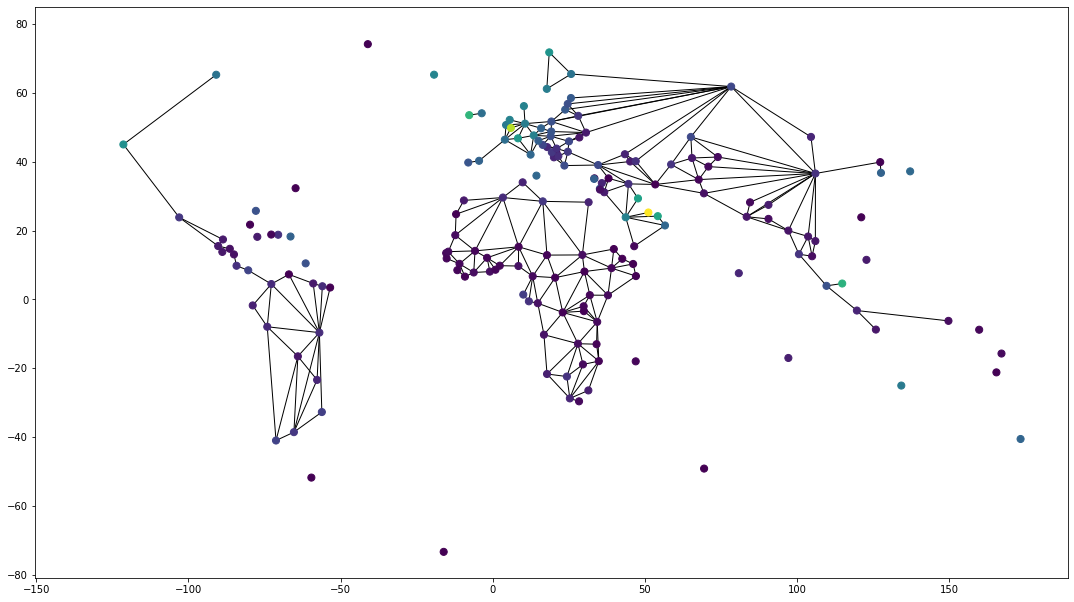

In [3]:
def display_graph(g):
    nx_graph, color_map = to_nx_graph(g)

    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    nx.draw(nx_graph, nx.get_node_attributes(nx_graph,'pos'), node_size=50, node_color=color_map)
    limits=plt.axis('on')
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.show()
    plt.close(fig)

def to_nx_graph(graph):
    export = nx.Graph()
    added_nodes = []
    color_map = []
    for node in graph.nodes.flatten():
        export.add_node(node, pos=node.coordinates)
        added_nodes.append(node)
        color_map.append(node.attrs['color'])
    for edge in graph.get_edges():
        export.add_edge(added_nodes[edge[0]], added_nodes[edge[1]])
    return export, color_map


display_graph(graph)

In [4]:
def create_distance_matrix(graph):
    matrix = np.zeros((len(graph.nodes), len(graph.nodes)))
    for i in range(len(graph.nodes)):
        for j in range(i + 1, len(graph.nodes)):
            node_i = graph.nodes[i]
            node_j = graph.nodes[j]

            if node_i in node_j.neighbours:
                # Set distance to connected nodes to be the differences in GDP
                distance = math.fabs(node_i.attrs['color'] - node_j.attrs['color'])
            else:
                # If nodes are not connected distance is set to infinity
                distance = np.inf

            matrix[i,j] = matrix [j,i] = distance
    return matrix

distance_matrix = create_distance_matrix(graph)

In [48]:
importlib.reload(hm)
def create_filtered_complex(distance_matrix):
    print("Generating Filtered Simplicial Complex")
    distance_matrix = distance_matrix.copy()
    distance_matrix[distance_matrix == 0] = np.inf
    filtered_simplexes = np.array([np.zeros(len(distance_matrix[0])) for _ in range(distance_matrix.shape[0])])
    labels = [0. for _ in range(distance_matrix.shape[0])]

    min_index = np.unravel_index(np.argmin(distance_matrix, axis=None), distance_matrix.shape)
    count = 1
    while distance_matrix[min_index] != np.inf:
        if count % 50 == 0:
            print(f"    Working...")
        count += 1

        new_complexes = [list(min_index)]
        while len(new_complexes) > 0:
            next_complexes = []
            for complex in new_complexes:
                filtered_simplexes = hm.__add_complex(complex, filtered_simplexes)
                labels.append(distance_matrix[min_index] / 2)
                next_complexes += hm.__new_complexes_created(complex, filtered_simplexes, max_dimensions=2)
            new_complexes = next_complexes

        distance_matrix[min_index] = distance_matrix[(min_index[1],min_index[0])] = np.inf
        min_index = np.unravel_index(np.argmin(distance_matrix, axis=None), distance_matrix.shape)

    print("Finished generating Filtered Simplicial Complex")
    return filtered_simplexes, labels

filtered_complex, labels = create_filtered_complex(distance_matrix)

Generating Filtered Simplicial Complex
    Working...
    Working...
    Working...
    Working...
    Working...
    Working...
Finished generating Filtered Simplicial Complex


In [ ]:
importlib.reload(hm)
tuples = hm.filtered_complexes_to_tuples(filtered_complex, labels)
# print(tuples.shape)
# print(tuples)
# print(tuples[:,0])
# print(tuples[:,1])
plt.scatter(tuples[:, 0], tuples[:, 1])
plt.show()
plt.close()